# COVID-19 modeling using SEIR and ARIMA
"Spiewajace fortepiany" team solution for "Ustawka 2020" hackathon.

### Setup

**Action**: Restart kernel after updating packages.

### Read data from Cloud Object Storage
The data has been uploaded to project first. Next option `insert to code as pandas df` can be used to insert COS connection.

You can download the data from: https://raw.githubusercontent.com/JanWasilewski/Hackaton/master/data/covid19.csv

In [4]:
data_df.head()

,Date,Confirmed daily,Recovered,Official deaths daily
0,4 May 2020,313,150,19
1,5 May 2020,406,185,18
2,6 May 2020,311,375,18
3,7 May 2020,303,207,22
4,8 May 2020,337,322,21


### SEIR model

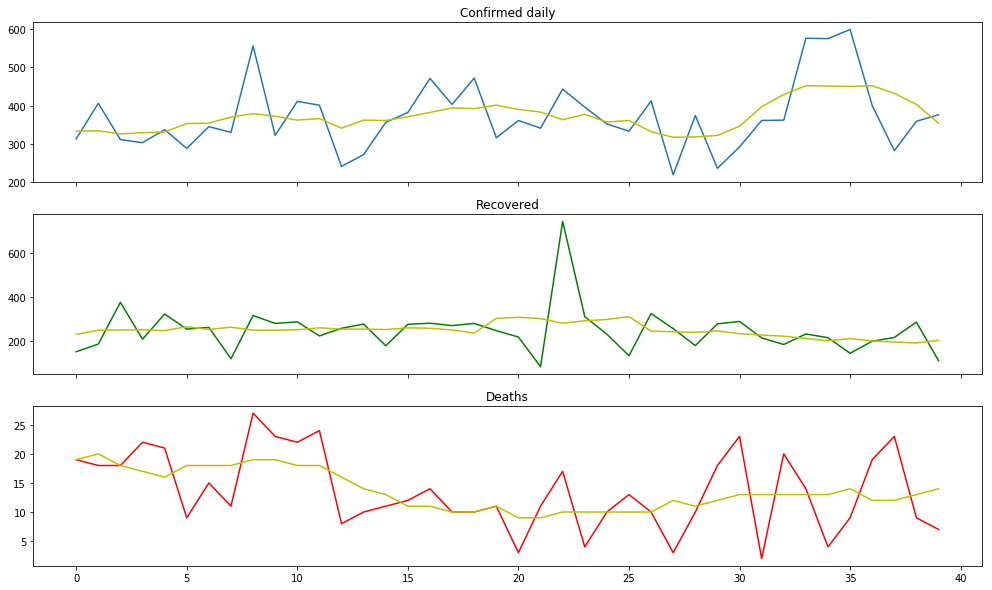

In [5]:
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data to train SEID-RDe model 
data = data_df.fillna(0)

data_train = data.iloc[:40,:]
N_data_train = data_train.shape[0]

R_obs_w = np.round(np.array(data_train["Confirmed daily"]))
O_obs_w = np.round(np.array(data_train["Recovered"]))
Z_obs_w = np.round(np.array(data_train["Official deaths daily"]))

R_obs_SEIR = R_obs_w.copy()
O_obs_SEIR = O_obs_w.copy()
Z_obs_SEIR = Z_obs_w.copy()

for j in range(len(R_obs_w)):
    R_obs_SEIR[j] = round(sum(R_obs_w[max(j-3,0):min(j+4, len(R_obs_w))])/len(R_obs_w[max(j-3,0):min(j+4, len(R_obs_w))]))
    O_obs_SEIR[j] = round(sum(O_obs_w[max(j-3,0):min(j+4, len(O_obs_w))])/len(O_obs_w[max(j-3,0):min(j+4, len(O_obs_w))]))
    Z_obs_SEIR[j] = round(sum(Z_obs_w[max(j-3,0):min(j+4, len(Z_obs_w))])/len(Z_obs_w[max(j-3,0):min(j+4, len(Z_obs_w))]))
      
# number of days to forecast
N_predict = 200

fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(N_data_train), R_obs_w)
axes[0].plot(range(N_data_train), R_obs_SEIR, "y")
axes[0].set_title('Confirmed daily')
axes[1].plot(range(N_data_train), O_obs_w,"g")
axes[1].plot(range(N_data_train), O_obs_SEIR, "y")
axes[1].set_title('Recovered')
axes[2].plot(range(N_data_train), Z_obs_w, "r" )
axes[2].plot(range(N_data_train), Z_obs_SEIR, "y")
axes[2].set_title('Deaths')
plt.show()

## Bayesian SEIR trend analysis

In [25]:
# number of samples in MCMC
N_samples = 1e5
#N_samples = 10

In [26]:
# Differential equation system
from functools import reduce
from scipy.integrate import odeint

def system(y, t, beta, sigma, gamma, delta, ni):
    Sw, Ew, Iw, Rw, Ow, Zw = y
    dydt = [-np.exp(beta) * Iw * Sw,
            np.exp(beta) * Iw * Sw - np.exp(sigma) * Ew,
            np.exp(sigma) * Ew - np.exp(gamma) * Iw,
            np.exp(gamma) * Iw - (np.exp(delta) + np.exp(ni)) * Rw,
            np.exp(delta) * Rw,
            np.exp(ni) * Rw]
    return dydt

def Rw_solution(y0, beta, sigma, gamma, delta, ni, t = np.linspace(0, N_data_train, num = N_data_train + 1)):
    solution = odeint(system, y0, t, args=(beta, sigma, gamma, delta, ni))
    R_change = solution[1: ,3] - solution[:len(solution) - 1, 3]
    Z_change = solution[1: ,5] - solution[:len(solution) - 1, 5]
    O_change = solution[1: ,4] - solution[:len(solution) - 1, 4]
    return R_change + O_change + Z_change, Z_change, O_change

In [27]:
# SEIR initial values
SEIR_init = np.array([35979104, 1081, 5777, 14037, 0, 0])
N = sum(SEIR_init)
# max(SEIR_init) = 1 for the Rw_solution solusion stability
SEIR_init_norm = SEIR_init / N
  
tfd = tfp.distributions

# Define join probability

# params = [beta, gamma, sigma, delta, eta]
def joint_log_prob(params, R_obs_SEIR = R_obs_SEIR, O_obs_SEIR = O_obs_SEIR,
                   Z_obs_SEIR = Z_obs_SEIR, SEIR_init_norm = SEIR_init_norm):
            
    prior = tf.cast(tfd.MultivariateNormalDiag(loc = [np.log(1/5), np.log(1/5), np.log(1/3.5),
                                            np.log(1/60), np.log(1/800)], scale_diag = [100]*5).log_prob(params), 'float32')
    
    
    # hyperpriors
    sigma_R = 100
    sigma_Z = 25
    sigma_O = 100

       
    R_SEIR, Z_SEIR, O_SEIR =  Rw_solution(SEIR_init_norm, beta = params[0][0], gamma = params[0][1],
                                          sigma = params[0][2], delta = params[0][3], ni = params[0][4])
    
    # Scale back
    R_SEIR = tf.Variable(N * R_SEIR, dtype = tf.float32)
    Z_SEIR = N * Z_SEIR
    O_SEIR = N * O_SEIR

    likelihood_R = tfd.NegativeBinomial(probs = 1 - R_SEIR/(R_SEIR + sigma_R),
                                                 total_count = tf.Variable((R_SEIR**2)/(sigma_R), dtype = "float32")).log_prob(R_obs_SEIR)
    likelihood_Z = tfd.NegativeBinomial(probs = tf.Variable(1 - Z_SEIR/(Z_SEIR + sigma_Z), dtype = "float32"),
                                                 total_count = tf.Variable((Z_SEIR**2)/(sigma_Z), dtype = "float32")).log_prob(Z_obs_SEIR)
     
    likelihood_O = tfd.NegativeBinomial(probs = tf.Variable(1 - O_SEIR/(O_SEIR + sigma_O), dtype = "float32"),
                                                 total_count = tf.Variable((O_SEIR**2)/(sigma_O), dtype = "float32")).log_prob(O_obs_SEIR)
         
    return prior + sum(likelihood_O) + sum(likelihood_Z) + sum(likelihood_R) 

In [28]:
# Sampling
hmc = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=joint_log_prob,
        seed = 1)

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results = int(N_samples),
    num_burnin_steps = int(0.3*N_samples),
    current_state = tf.constant([np.log(1/5), np.log(1/5), np.log(1/5),
                                 np.log(1/3.5), np.log(1/60)],
                                shape = (1,5)),
    kernel=hmc)

sample = samples[:,0,:]

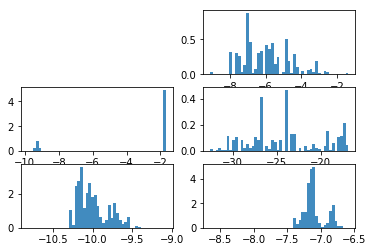

In [41]:
# Plot posterior distributions

for i in range(5):    
    ax = plt.subplot(3, 2, i + 2)
    plt.hist(tf.reshape(sample[:,i], (-1,)).numpy(), histtype = 'stepfilled', bins = 50, alpha = 0.85,
             label = None, density = True)

In [42]:
# Bayesian prediction 
trend_sample = []
for i in range(int(N_samples)):
    R_SEIR, Z_SEIR, O_SEIR = Rw_solution(SEIR_init_norm,
                             beta = sample[i, 0],
                             gamma = sample[i, 1],
                             sigma = sample[i, 2],
                             delta = sample[i, 3],
                             ni = sample[i, 4],
                             t = np.linspace(0, N_data_train + N_predict, num = N_data_train + N_predict + 1))
    R_SEIR = R_SEIR * N
    Z_SEIR = Z_SEIR * N
    O_SEIR = O_SEIR * N
    
    trend_sample.append(np.array([R_SEIR, Z_SEIR, O_SEIR]))

In [43]:
# means and standard deviations of result distributions
trend = np.mean(np.array(trend_sample), axis = 0)
trend_std = np.std(np.array(trend_sample), axis = 0)

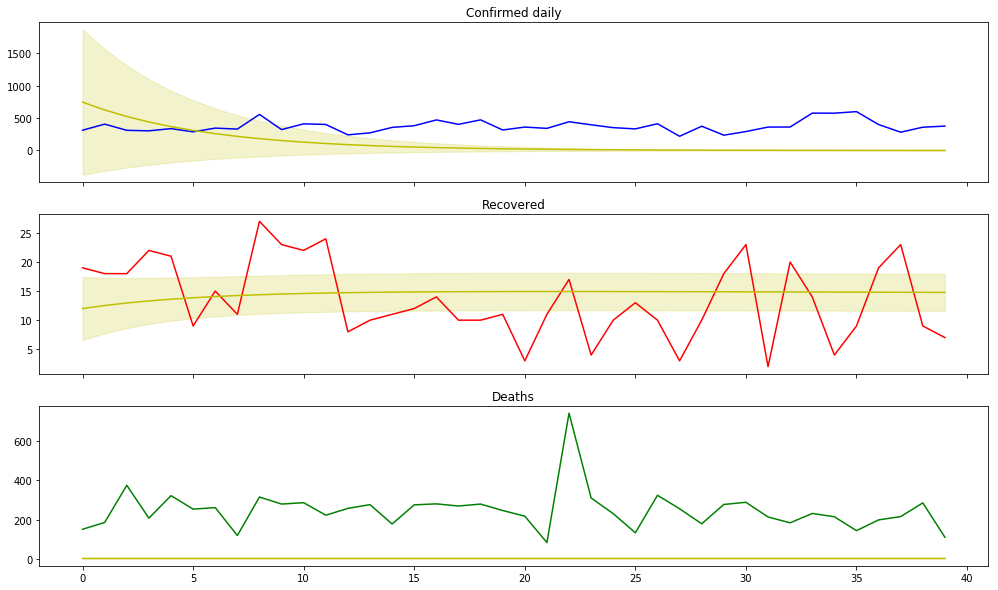

In [44]:
# SEIR for trend - plots
fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(N_data_train), R_obs_w, "b")
axes[0].plot(range(N_data_train), trend[0, :N_data_train], color="y")
axes[0].fill_between(range(N_data_train),
                     trend[0, :N_data_train] + 3 * trend_std[0, :N_data_train],
                     trend[0, :N_data_train] - 3 * trend_std[0, :N_data_train],
                     alpha=0.2, color="y")
axes[0].set_title('Confirmed daily')

axes[1].plot(range(N_data_train), Z_obs_w, "r" )
axes[1].plot(range(N_data_train), trend[1, :N_data_train], color="y")
axes[1].fill_between(range(N_data_train),
                     trend[1, :N_data_train] + 3 * trend_std[1, :N_data_train],
                     trend[1, :N_data_train] - 3 * trend_std[1, :N_data_train],
                     alpha=0.2, color="y")

axes[1].set_title('Recovered')

axes[2].plot(range(N_data_train), O_obs_w,"g")
axes[2].plot(range(N_data_train), trend[2, :N_data_train], color="y")
axes[2].fill_between(range(N_data_train),
                     trend[2, :N_data_train] + 3 * trend_std[2, :N_data_train],
                     trend[2, :N_data_train] - 3 * trend_std[2, :N_data_train],
                     alpha=0.2, color="y")

axes[2].set_title('Deaths')

plt.show()

## Residual analysis

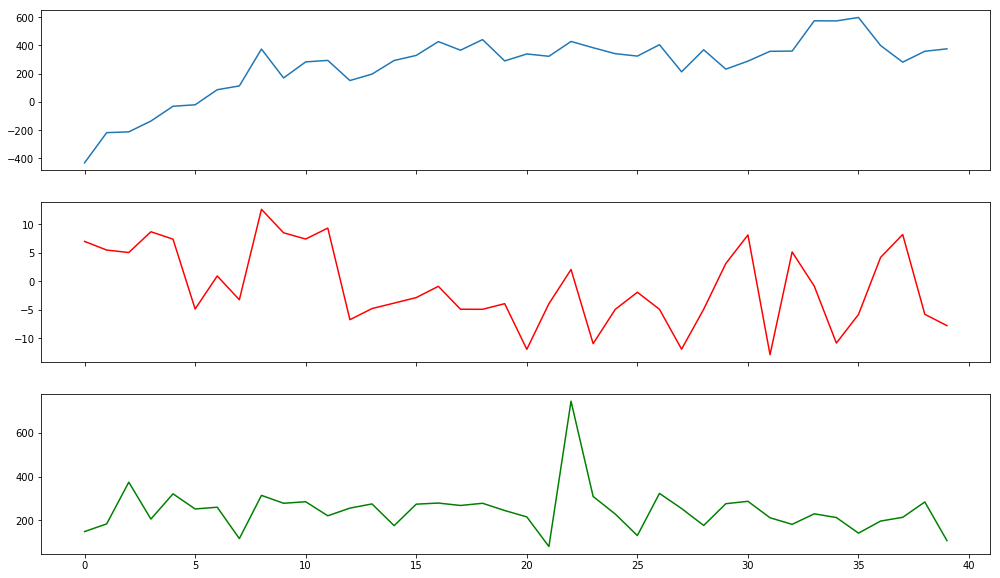

In [45]:
residual_R = R_obs_w - trend[0, :N_data_train]
residual_Z = Z_obs_w - trend[1, :N_data_train]
residual_O = O_obs_w - trend[2, :N_data_train]


fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(N_data_train), residual_R)
axes[1].plot(range(N_data_train), residual_Z, "r" )
axes[2].plot(range(N_data_train), residual_O,"g")

plt.show()

In [46]:
from pmdarima.arima import auto_arima

stepwise_model_R = auto_arima(residual_R, start_p=1, start_q=1,
                       max_p=3, max_q=3,max_d=2, m=7,
                       start_P=0, start_Q = 0,max_D = 2, seasonal=False,
                       D=1,d = 1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=False, n_jobs= -1, maxiter = 200)


stepwise_model_Z = auto_arima(residual_Z, start_p=1, start_q=1,
                       max_p=3, max_q=3,max_d=2, m=7,
                       start_P=0, start_Q = 0,max_D = 2, seasonal=False,
                       D=1,d = 1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=False, n_jobs= -1, maxiter = 200)


stepwise_model_O = auto_arima(residual_O, start_p=1, start_q=1,
                       max_p=3, max_q=3,max_d=2, m=7,
                       start_P=0, start_Q = 0,max_D = 2, seasonal=False,
                       D=1,d = 1, trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=False, n_jobs= -1, maxiter = 200)

print(stepwise_model_R)
print(stepwise_model_Z)
print(stepwise_model_O)


Total fit time: 3.190 seconds
Total fit time: 0.801 seconds
Total fit time: 0.883 seconds
ARIMA(maxiter=200, order=(1, 1, 0), suppress_warnings=True)
ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True)
ARIMA(maxiter=200, order=(0, 1, 1), suppress_warnings=True)


In [47]:
# Residual forecasts

def predict_resid(past_3weeks, N_predict=1):
    R_past, Z_past, O_past = past_3weeks
    
    stepwise_model_R.fit(R_past)
    stepwise_model_Z.fit(Z_past)
    stepwise_model_O.fit(O_past)

    residual_R_forecast = stepwise_model_R.predict(n_periods = N_predict)
    residual_Z_forecast = stepwise_model_Z.predict(n_periods = N_predict)
    residual_O_forecast = stepwise_model_O.predict(n_periods = N_predict)
    return residual_R_forecast, residual_Z_forecast, residual_O_forecast 

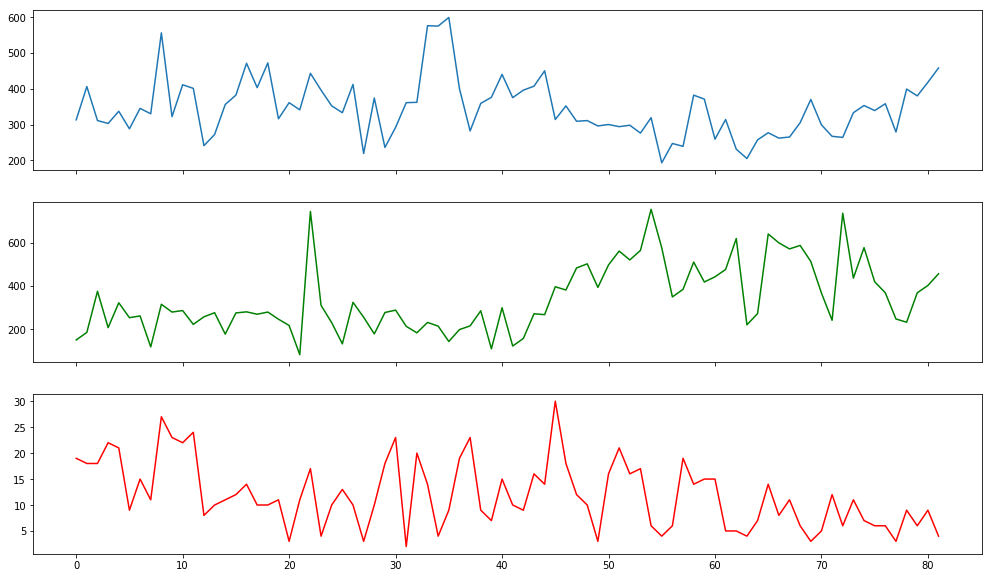

In [48]:
N_data = data.shape[0]

R_obs_new = np.round(np.array(data["Confirmed daily"]))
O_obs_new = np.round(np.array(data["Recovered"]))
Z_obs_new = np.round(np.array(data["Official deaths daily"]))
date_new = data["Date"]

fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(N_data), R_obs_new)
axes[1].plot(range(N_data), O_obs_new,"g")
axes[2].plot(range(N_data), Z_obs_new, "r" )
plt.show()

## Predictions

In [49]:
# final predictions
def forecastDRDe(day):
    past_3weeks = (R_obs_new[:day] - trend[0, :day], Z_obs_new[:day] - trend[1, :day], O_obs_new[:day] - trend[2, :day])
    
    residual_R, residual_Z, residual_O = predict_resid(past_3weeks)
    print("Residuals: ", residual_R, residual_Z, residual_O)
    R_forecast = trend[0, day] + residual_R
    Z_forecast = trend[1, day] + residual_Z
    O_forecast = trend[2, day] + residual_O
    print("Trend: ", trend[0, day], trend[1, day], trend[2, day])
    return R_forecast, Z_forecast, O_forecast 

In [50]:
# Forcasts for hackathon
hacathon_beg = 42
hacathon_end = 54
R_forecast = []
Z_forecast = []
O_forecast = []
for i in range(hacathon_beg,hacathon_end):
    print(date_new[i])
    R_predicted, Z_predicted, O_predicted = forecastDRDe(i)
    R_forecast.append(R_predicted[0])
    Z_forecast.append(Z_predicted[0])
    O_forecast.append(O_predicted[0])
    
R_true = R_obs_new[hacathon_beg:hacathon_end] 
Z_true = Z_obs_new[hacathon_beg:hacathon_end]
O_true = O_obs_new[hacathon_beg:hacathon_end]

15 June 2020
Residuals:  [423.50315427] [-3.94598233] [219.44869614]
Trend:  0.5864665244979617 14.733322418735924 0.8167554660838675
16 June 2020
Residuals:  [412.94344328] [-4.51846253] [212.39903788]
Trend:  0.518032102605168 14.720730277420424 0.8160590519574752
17 June 2020
Residuals:  [427.44289504] [-3.63160667] [216.31868452]
Trend:  0.44233310478104615 14.708167234526242 0.8153638514370871
18 June 2020
Residuals:  [459.59929589] [-3.23368857] [219.58518833]
Trend:  0.38023686546761853 14.695560535909545 0.8146665508060604
19 June 2020
Residuals:  [385.48935895] [0.95821771] [233.84143623]
Trend:  0.3369325665625496 14.682890032393995 0.8139658322625221
20 June 2020
Residuals:  [359.54757808] [1.6138741] [245.76937239]
Trend:  0.30318209846531036 14.670191715925975 0.8132633761376727
21 June 2020
Residuals:  [344.37697684] [0.33869519] [265.34982334]
Trend:  0.27298340660162873 14.657487321085432 0.8125606263258804
22 June 2020
Residuals:  [329.57884132] [-0.91058438] [371.2947

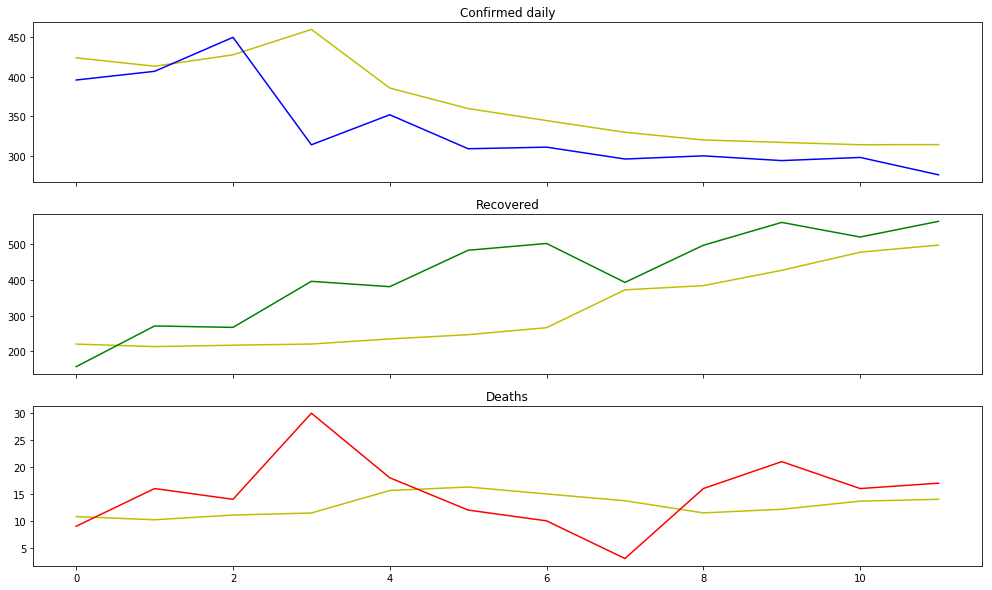

In [51]:
fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(len(R_forecast)), R_forecast, "y")
axes[0].plot(range(len(R_forecast)), R_true, "b")
axes[0].set_title('Confirmed daily')
axes[1].plot(range(len(R_forecast)), O_forecast, "y")
axes[1].plot(range(len(R_forecast)), O_true,"g")
axes[1].set_title('Recovered')
axes[2].plot(range(len(R_forecast)), Z_forecast, "y")
axes[2].plot(range(len(R_forecast)), Z_true, "r" )
axes[2].set_title('Deaths')
plt.show()

## Evaluation

In [52]:
error_daily_R = R_forecast - R_true
error_daily_Z = Z_forecast - Z_true
error_daily_O = O_forecast - O_true

print("Mean error")
print('Confirmed', np.mean(error_daily_R))
print('Recovered', np.mean(error_daily_Z))
print('Deaths', np.mean(error_daily_O), "\n")

print("Mean squared error")
print('Confirmed', np.mean(error_daily_R**2))
print('Recovered', np.mean(error_daily_Z**2))
print('Deaths', np.mean(error_daily_O**2), "\n")

print("Min squared error")
print('Confirmed', np.min(error_daily_R**2))
print('Recovered', np.min(error_daily_Z**2))
print('Deaths', np.min(error_daily_O**2), "\n")

print("Max squared error")
print('Confirmed', np.max(error_daily_R**2))
print('Recovered', np.max(error_daily_Z**2))
print('Deaths', np.max(error_daily_O**2), "\n")

print("Joint min square error")
print(np.min(error_daily_R**2 + error_daily_Z**2 + error_daily_O**2))

Mean error
Confirmed 34.00308864536868
Recovered -2.2103347151074284
Deaths -101.30556537377595 

Mean squared error
Confirmed 2607.707689358164
Recovered 55.526633998258156
Deaths 17586.48052093707 

Min squared error
Confirmed 41.750664139418
Recovered 3.1945845861804374
Deaths 436.5346099439978 

Max squared error
Confirmed 21310.02398309388
Recovered 343.66219107669565
Deaths 55893.17011164012 

Joint min square error
1695.7793203364797


---